Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Processing file: Merged01.csv

Processing file: Merged02.csv

Processing file: Merged03.csv

Processing file: Merged04.csv

Processing file: Merged05.csv
Standardized
ICA done
Running KMeans...
Cluster labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Counts per cluster: [ 18681 680160 659004 547048 308665 102982  12273     63    367   2877
 531365   2765   3482 287959    246  31748      6  30637  12649  58444
  19429    268  35157  40239   6760    334  12736     26   9615     16
    280     11  11180   7075  76397  37353      5   8613  21649    964]
Cluster 0 assigned to class DDOS-RSTFINFLOOD: 100.0% pure
Cluster 1 assigned to class DDOS-SYN_FLOOD: 42.5% pure
Cluster 2 assigned to class DDOS-UDP_FLOOD: 62.3% pure
Cluster 3 assigned to class DDOS-ICMP_FLOOD: 99.9% pure
Cluster 

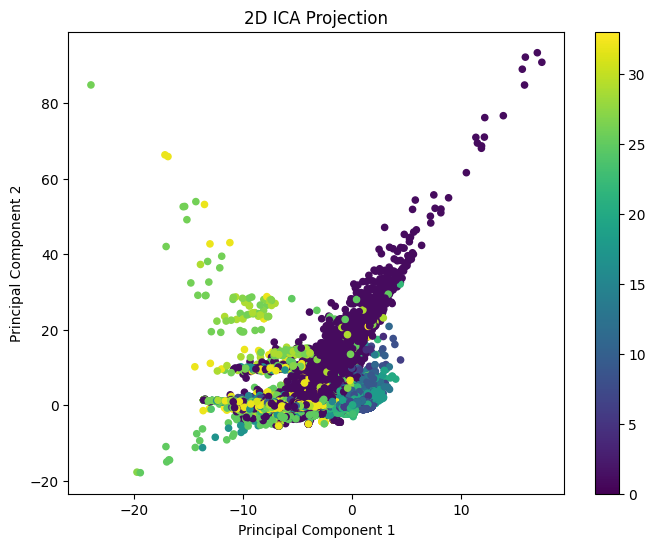

<ipython-input-8-478192afd351>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Count', data=cluster_data, palette='Set2')


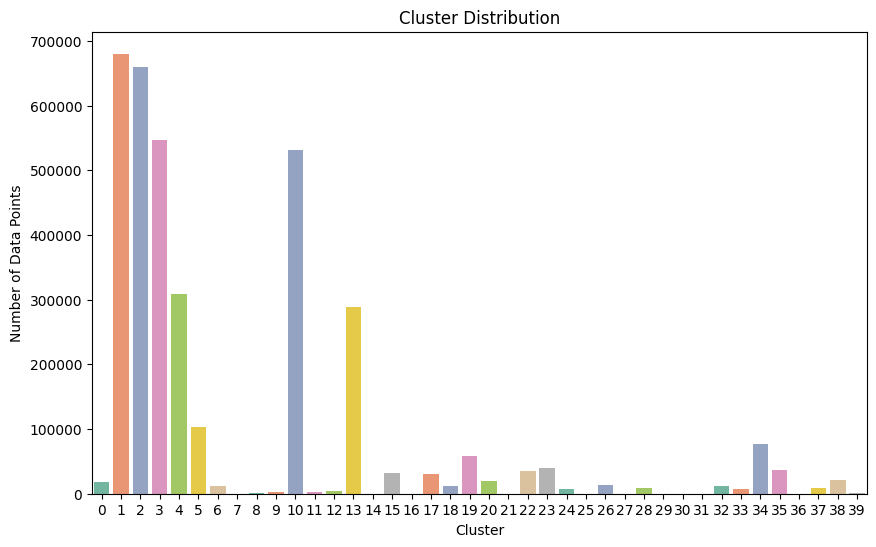

<ipython-input-8-478192afd351>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_ids, y=cluster_purities, palette='coolwarm')


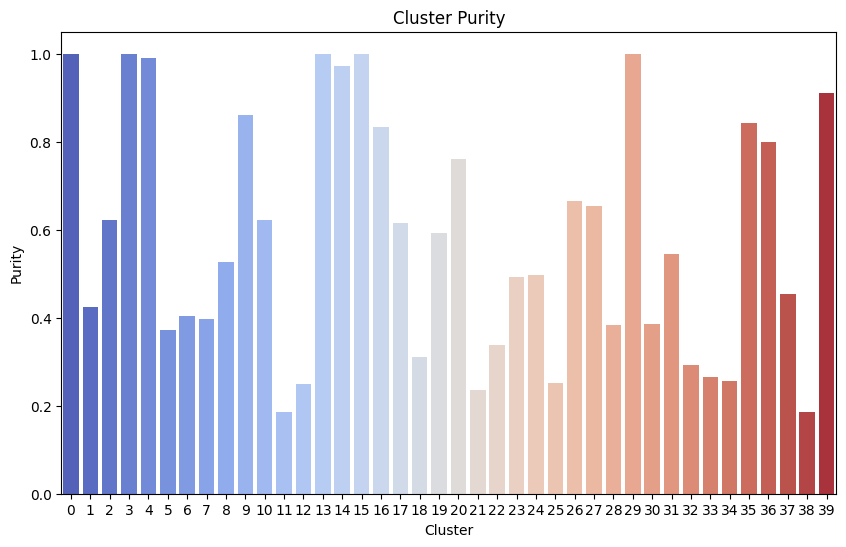

In [ ]:
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans
from collections import Counter
from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


def plot_2d_projection(features, labels, title="2D Projection"):
    """Plot the 2D projection of the features using PCA or ICA"""
    # Use LabelEncoder to convert labels into numeric values
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # PCA for 2D projection
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)

    # Plotting the 2D scatter plot with numeric labels
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_encoded, cmap='viridis', s=20)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

def plot_cluster_distribution(cluster_labels):
    """Plot the distribution of data points in each cluster."""
    cluster_counts = Counter(cluster_labels)
    cluster_data = pd.DataFrame(cluster_counts.items(), columns=['Cluster', 'Count'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Cluster', y='Count', data=cluster_data, palette='Set2')
    plt.title("Cluster Distribution")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Data Points")
    plt.show()

def plot_cluster_purity(assigned_clusters):
    """Plot the purity of each cluster."""
    cluster_purities = [p[2] for p in assigned_clusters]
    cluster_ids = [p[0] for p in assigned_clusters]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=cluster_ids, y=cluster_purities, palette='coolwarm')
    plt.title("Cluster Purity")
    plt.xlabel("Cluster")
    plt.ylabel("Purity")
    plt.show()

def main():
    # Mount Google Drive
    drive.mount('/content/drive')

    # Path to the folder containing your CSV files
    folder_path = '/content/drive/MyDrive/ciciot2023/'

    # List all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Initialize an empty list to store all the dataframes
    data_frames = []

    # Iterate over each CSV file, load it, and append to the list
    for file_name in csv_files:
        file_path = os.path.join(folder_path, file_name)

        print(f"\nProcessing file: {file_name}")

        # Load the dataset from the current CSV file
        df = pd.read_csv(file_path)

        # Preprocessing: handle infinite values and missing values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)

        data_frames.append(df)  # Add the DataFrame to the list

    # Concatenate all the dataframes into one combined dataframe
    combined_df = pd.concat(data_frames, ignore_index=True)

    # Extract labels and features
    labels = combined_df['Label'].tolist()
    features = combined_df.drop(columns=['Label'])

    # Standardize the features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    print("Standardized")

    # Perform ICA (Independent Component Analysis)
    n_components = 10
    ica = FastICA(n_components=n_components, random_state=42)
    features = ica.fit_transform(features)
    print("ICA done")

    # Run KMeans clustering
    n_clusters = 40
    km = KMeans(
        n_clusters=n_clusters,
        n_init=10,
        max_iter=300,
        tol=1e-4,
        random_state=42
    )
    print("Running KMeans...")
    km.fit(features)
    optimal_centroids = km.cluster_centers_
    cluster_labels = km.labels_

    # Print clustering information
    unique_labels, counts = np.unique(cluster_labels, return_counts=True)

    print("Cluster labels:", unique_labels)
    print("Counts per cluster:", counts)

    # Create a DataFrame to store cluster results
    df_results = pd.DataFrame({'cluster': cluster_labels, 'true_label': labels})

    cluster_composition = df_results.groupby('cluster')['true_label'].value_counts().unstack(fill_value=0)

    assigned_clusters = []

    # Iterate over each cluster to compute its purity and assign a label if it meets the threshold
    for cluster, counts in cluster_composition.iterrows():
        total = counts.sum()
        majority_label = counts.idxmax()
        majority_count = counts.max()
        purity = majority_count / total
        assigned_clusters.append((cluster, majority_label, purity))
        print(f"Cluster {cluster} assigned to class {majority_label}: {purity*100:.1f}% pure")

    # Calculate the average purity of the clusters that were assigned a class label
    if assigned_clusters:
        avg_purity = sum(p[2] for p in assigned_clusters) / len(assigned_clusters)
        print(f"\nAverage purity for assigned clusters: {avg_purity*100:.1f}%")
        unique_assigned_labels = set([p[1] for p in assigned_clusters])
        diversity = len(unique_assigned_labels)
        print(f"Cluster diversity (number of distinct classes with a pure cluster): {diversity}")
    else:
        print("No clusters meet the purity threshold of 80%.")

    # Plot the 2D projection of the features
    plot_2d_projection(features, labels, title="2D ICA Projection")

    # Plot the cluster distribution
    plot_cluster_distribution(cluster_labels)

    # Plot the cluster purity
    plot_cluster_purity(assigned_clusters)

if __name__ == '__main__':
    main()
